# CRNN文本识别

论文：
[An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](http://arxiv.org/abs/1507.05717)

In [9]:
import os
import math
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


In [10]:
batch_size = 32
#lr=0.0005  #使用Adadelta优化器，不需要学习率，使用Adam时需要
num_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
char_to_int = {char: i for i, char in enumerate('*0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ- ')}
num_classes = len(char_to_int)
print(num_classes)

65


## 1. 定义网络

In [17]:


class CRNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(CRNN, self).__init__()

        # Convolutional Layers
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1), #1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1)),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), #5
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #6
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1)),

            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0), #7
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        # Recurrent Laysers
        self.lstm1 = nn.LSTM(input_size=512, hidden_size=256, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.size()
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = self.fc(x)

        return x

crnn = CRNN(num_classes=num_classes).to(device)

## 2. 数据加载

In [18]:
import os
from PIL import Image
import torch
from torchvision import transforms

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get file path
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        # Open image
        image = Image.open(img_name).convert('L')
        # Extract label from filename
        label = self.file_list[idx].split('_')[0]
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((32, 100)),  # Resize to fixed size (height, width)
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)  # Use tuple for both mean and std
])


# Create dataset and dataloader
train_dataset = CustomDataset(root_dir='/home/han/Documents/SRP/dataset/traindata/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)


In [19]:

def images_show(imgs,labs=[]):
    i=0
    #w = math.ceil(len(imgs)/2)
    for img in imgs:
        plt.title(labs[i])
        #plt.imshow(img.cpu().squeeze(0))
        plt.imshow(img.cpu().squeeze(),plt.cm.gray)
        plt.show()
        i+=1
        if  i >= 8:
            print(f"Maximium Images for images_show: {i}")
            break

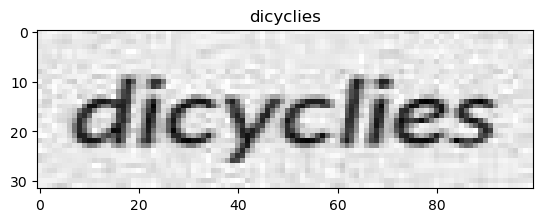

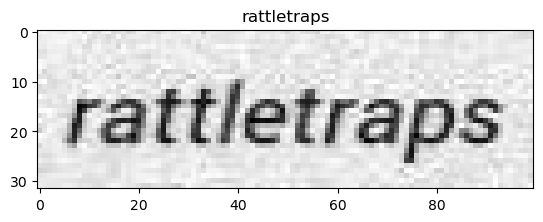

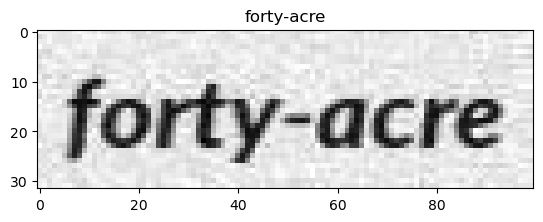

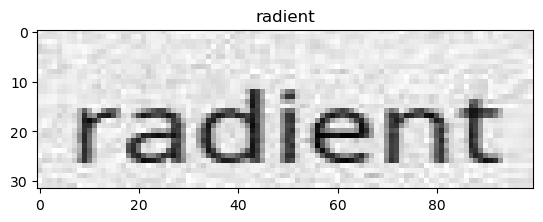

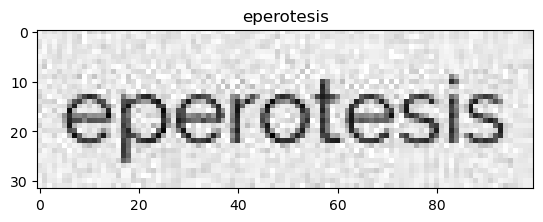

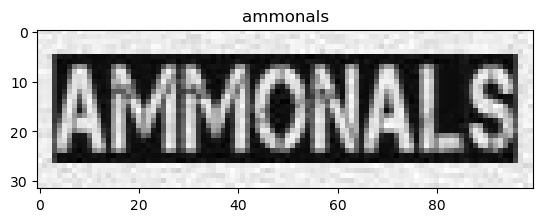

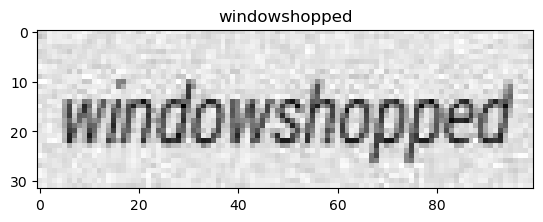

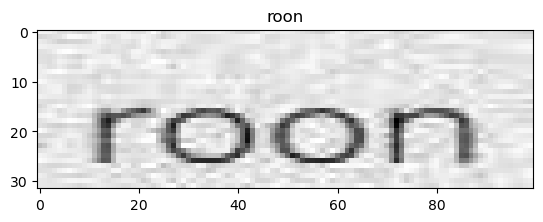

Maximium Images for images_show: 8


In [20]:
for i, (images, labels) in enumerate(train_loader):
    images_show(images,labels)
    break

## 3. 优化器与损失函数

In [21]:
# 优化器
#optimizer = torch.optim.Adam(crnn.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(crnn.parameters())

# 损失函数
criterion = nn.CTCLoss()

## 4. 训练

In [22]:
def encode_labels(labels):

    encoded = []
    lengths = []
    for label in labels:
        encoded_label = [char_to_int[ch] for ch in label]
        encoded.extend(encoded_label)
        lengths.append(len(encoded_label))
    return torch.tensor(encoded), lengths

print(len(char_to_int))

# 训练模型

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        
        optimizer.zero_grad()

        outputs = crnn(images)
        outputs = outputs.log_softmax(2)
        
        # Encode labels into format suitable for CTC
        encoded_labels, label_lengths = encode_labels(labels)
        
        #print(encoded_labels)
        #print("---------")
        
        encoded_labels = encoded_labels.to(device)
        output_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long)

        loss = criterion(outputs, encoded_labels, output_lengths, torch.tensor(label_lengths))
        #print(f"loss:{loss}")
        loss.backward()

        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

65
Epoch [1/30], Step [10/313], Loss: 3.4756155014038086
Epoch [1/30], Step [20/313], Loss: 3.4512743949890137
Epoch [1/30], Step [30/313], Loss: 3.388484001159668
Epoch [1/30], Step [40/313], Loss: 3.3849270343780518
Epoch [1/30], Step [50/313], Loss: 3.407365083694458
Epoch [1/30], Step [60/313], Loss: 3.2823128700256348
Epoch [1/30], Step [70/313], Loss: 3.1954331398010254
Epoch [1/30], Step [80/313], Loss: 3.2822930812835693
Epoch [1/30], Step [90/313], Loss: 3.251730442047119
Epoch [1/30], Step [100/313], Loss: 3.1958558559417725
Epoch [1/30], Step [110/313], Loss: 3.3246164321899414
Epoch [1/30], Step [120/313], Loss: 3.316563606262207
Epoch [1/30], Step [130/313], Loss: 3.168177604675293
Epoch [1/30], Step [140/313], Loss: 3.2563834190368652
Epoch [1/30], Step [150/313], Loss: 3.2450475692749023
Epoch [1/30], Step [160/313], Loss: 3.294084072113037
Epoch [1/30], Step [170/313], Loss: 3.1786892414093018
Epoch [1/30], Step [180/313], Loss: 3.2703018188476562
Epoch [1/30], Step [19

## 保存训练权重

In [23]:
PATH = './crnn_str_single_simple.pth'
torch.save(crnn.state_dict(), PATH)

## 测试评估

In [24]:
#device = "cpu"
PATH = './crnn_str_single_simple.pth'
net = CRNN(num_classes=num_classes).to(device)
#net = CRNN(config).to(device)

if device == "cpu":
    net.load_state_dict(torch.load(PATH, map_location='cpu'))
else:
    net.load_state_dict(torch.load(PATH))

net.eval()


test_dataset = CustomDataset(root_dir='/home/han/Documents/SRP/dataset/testdata/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)  #此处batch_size必须为1

In [25]:
# 定义字符到整数的逆映射
int_to_char = {i: c for c, i in char_to_int.items()}


def decode_labels(preds):
    decoded_text = ""
    prevalue = 0
    for pred in preds:
        value = pred.item()
        if value == 0:
            prevalue = value
            continue
        if value == prevalue:
            continue
        if value in int_to_char:
            decoded_text += int_to_char[value]
        prevalue = value
    return decoded_text

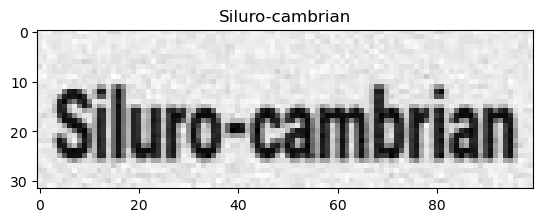

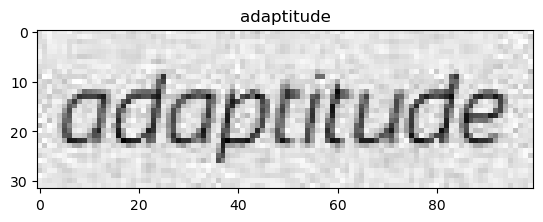

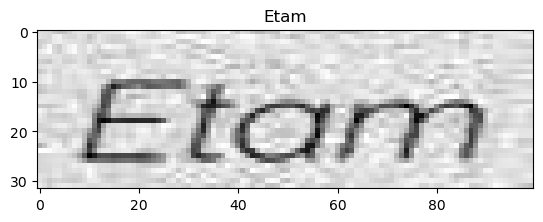

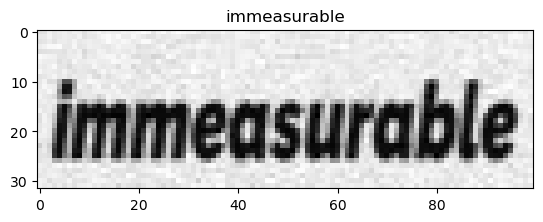

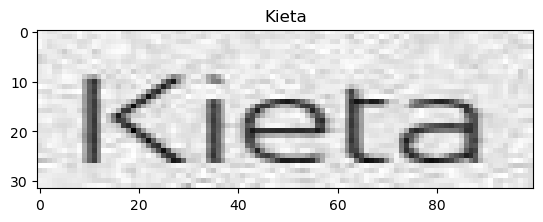

misarrangement
misarangement
food-productive
fod-productive
patternmaker
paternmaker
tyrosinuria
tyrosinurila
test procees:100/1000
Skimos
skimos
Aristomachus
aristomachus
phytophylogeny
phytoplylagry
psychotherapies
nsxcrhotherapies
modernists
modernsts
Methodistically
methodistically
test procees:200/1000
test procees:300/1000
test procees:400/1000
test procees:500/1000
test procees:600/1000
test procees:700/1000
test procees:800/1000
test procees:900/1000
test procees:1000/1000
Test Accuracy: 93.50%


In [26]:

# 对测试数据进行评估
test_accuracy = 0.0
total_samples = 0

i=0
error_count = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = net(images)

        
        _, predicted = torch.max(outputs,2)  # 第2个维度是类别维度)

        #print(predicted)
        if(i<=4):
            images_show(images,[decode_labels(predicted)])
        if(decode_labels(predicted) ==  labels[0]):
            test_accuracy +=1
        else:
            if(error_count < 10):
                print(labels[0])
                print(decode_labels(predicted))
                error_count+=1
        total_samples += len(labels)
        i+=1
        if i==5:
            #break
            continue
        if((i+1)%100 == 0):
            print(f"test procees:{i+1}/{len(test_loader)}")

test_accuracy /= total_samples
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
